# Convert the sample png files to binary files and .cc and .h source files
When running the inference on the target micro-controller we need the sample png files as files of binary pixel values in case of MicroPython, or as C++ code.
For this to work, the initial pixel values, which are of float32 format (0..1) are converted into uint8 format (0..255)
Then the source files are created.
In the case of running the inference on MicroPython, we have a file system, where the images can be stored. In this case we produce
binary files again in uint8 format in order to save space in the micro-controller flash.

import the necessary libraries

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Read an image from the samples directory

In [2]:
def read_img(img_path):
  """Read MNIST image

  Args:
      img_path (str): path to a MNIST image

  Returns:
      np.array : image in the correct np.array format
  """
  image = Image.open(img_path)
  data = np.asarray(image, dtype=np.float32)   # converts the image into an array of pixel values
  if data.shape not in [(28, 28), (28, 28, 1)]:
    raise ValueError(
        "Invalid input image shape (MNIST image should have shape 28*28 or 28*28*1)"
    )
  # Normalize the image if necessary
  if data.max() > 1:
    data = data / 255.0
  # Model inference requires batch size one
  data = data.reshape((1, 28, 28))
  return data  

Try out the read_img function. 
Read all 10 images and plot them

In [3]:
pixel_data = [None]*10 # read all 10 digit images
for img in range(10):
    filename = "samples/sample{:d}.png".format(img)
    pixel_data[img] = read_img(filename)
    print("read image from file " + filename)

read image from file samples/sample0.png
read image from file samples/sample1.png
read image from file samples/sample2.png
read image from file samples/sample3.png
read image from file samples/sample4.png
read image from file samples/sample5.png
read image from file samples/sample6.png
read image from file samples/sample7.png
read image from file samples/sample8.png
read image from file samples/sample9.png


In [4]:
print("shape: ",pixel_data[0][0].shape)
print("dtype: ",pixel_data[0][0][0].dtype)
print("minimum value: ",pixel_data[0].min()," maximum value: ",pixel_data[0].max())

shape:  (28, 28)
dtype:  float32
minimum value:  0.0  maximum value:  1.0


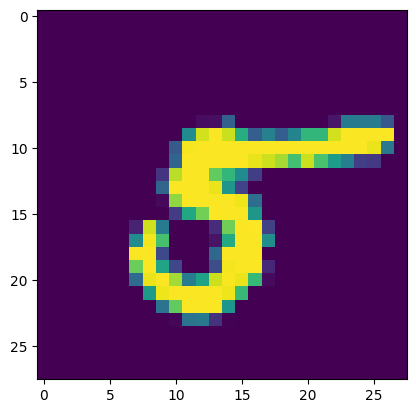

In [5]:
plt.set_cmap('viridis') # this is the default color map
plt.imshow(pixel_data[5][0])

<Figure size 640x480 with 0 Axes>

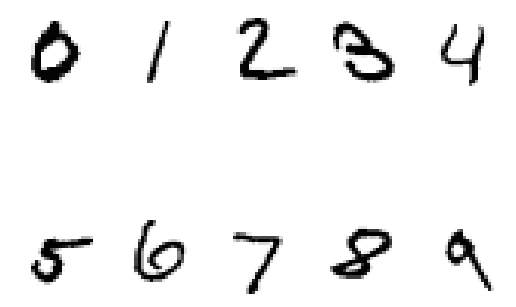

In [6]:
plt.set_cmap('Greys')
fig, axs = plt.subplots(2,5)
for i in range(2):
    for j in range(5):
        axs[i,j].axis('off')
        axs[i,j].imshow(pixel_data[5*i+j][0])

In [7]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path="models/number_model_quant.tflite")
interpreter.allocate_tensors() # Needed before execution

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In order to save these data to files it is reasonable to convert them to byte values (saves a factor 4 in space)

Get the quantization parameters

In [8]:
input_details = interpreter.get_input_details()[0]
input_quantization_parameters = input_details["quantization_parameters"]
input_scale, input_zero_point = input_quantization_parameters["scales"][0], input_quantization_parameters["zero_points"][0]
print("input scale: {:f}, input_zero_point: {:d}".format(input_scale,input_zero_point))
data_type = input_details["dtype"]
print("input data type: ",data_type)

input scale: 0.003922, input_zero_point: -128
input data type:  <class 'numpy.int8'>


In [9]:
def writeToBinFile(digit_data,filename):
    # the digit data come in as a float32 numpy array of shape (28,28)
    if digit_data.shape != (28,28):
        print("invalid_shape")
        return
    if digit_data[0][0].dtype != np.float32:
        print("digit data should have dtype np.float32")
        return
    # print("digit_data ok")
    # convert 0..1 to 0..255
    int8_digit_data = (digit_data / input_scale + input_zero_point).astype(data_type)
    with open(filename,"wb") as pixel_file:
        pixel_file.write(int8_digit_data)

Convert all 10 digit files to int8 format and save them to the bin_samples folder

In [10]:
try:
    os.mkdir("bin_samples")
except:
    pass
for img in range(10):
    filename="bin_samples/sample{:d}.bin".format(img)
    writeToBinFile(pixel_data[img].reshape(28,28),filename)

Write the pixels to a binary file

The files are found in the bin_samples folder. You can get their contents with _ghex_

## Convert .png file to a .cc and a .h file
Data are stored in uint8 format 0..255 converted from float32 format 0..1

In [11]:
import tflite_runtime.interpreter as tflite
import tensorflow as tf
interpreter = tflite.Interpreter(model_path="models/number_model_quant.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()[0]
input_quantization_parameters = input_details["quantization_parameters"]
input_scale, input_zero_point = input_quantization_parameters["scales"][0], input_quantization_parameters["zero_points"][0]
print("input scale: {:f}, input_zero_point: {:d}".format(input_scale,input_zero_point))

2025-09-22 17:53:45.772280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-22 17:53:45.772344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-22 17:53:45.773976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-22 17:53:45.782484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 17:53:46.854471: W tensorflow/compiler/tf2

input scale: 0.003922, input_zero_point: -128


In [12]:
def convert_png_to_cc(img_path,out_dir):
    image = Image.open(img_path)
    data = np.asarray(image, dtype=np.float32)
    if data.shape not in [(28, 28), (28, 28, 1)]:
        raise ValueError(
        "Invalid input image shape (MNIST image should have shape 28*28 or 28*28*1)"
    )
    # Normalize the image if necessary
    if data.max() > 1:
        data = data / 255.0
    data = data.reshape((28, 28))
    # print(data[0][0].dtype)
    # dequantize the result

    data = (data / input_scale + input_zero_point).astype(data_type)

    # print(data[0][0].dtype)
    # extract the filename without preceeding path
    filename = img_path.split('/')
    filename = filename[len(filename)-1]
    filename = os.path.splitext(filename)[0]
    # print(filename)
    cc_filename = out_dir + "/" + filename + "_data.cc"
    h_filename = out_dir + "/" + filename + "_data.h"
    # print(cc_filename, h_filename)
    # create the output directory if it does not exist yet
    try:
        os.mkdir(out_dir)
    except:
        pass
    # fill the .cc file
    cc_file = open(cc_filename,"w")
    cc_file.write("#include <cstdint>\n\n")
    cc_file.write('#include "' + h_filename  + "\n\n")
    cc_file.write("const insigned int g_" + filename + "_img_data_size=" + str(data.size) + ";\n")
    cc_file.write("alignas(16) const unsigned char g_" + filename + "_img_data[] = {\n")
    data= data.reshape((data.size))
    # print(data.shape)
    for pixel in data[:data.size-1]:
        cc_file.write("0x{:02x},".format(pixel))
    cc_file.write("0x{:02x}".format(data[data.size-1]) + "};")
    cc_file.close()
    # Now write the corresponding .h file
    h_file = open(h_filename,"w")
    h_file.write("#include <cstdint>\n\n")
    h_file.write("extern const unsigned int g_" + filename + "_img_data_size;\n")
    h_file.write("extern const unsigned char g_" + filename + "_img_data;\n")
    h_file.close()
    # print(cc_filename + " and " + h_filename + " successfully written")

Now generate the .cc and .h files. You can find it in the C++_code folder

In [13]:
for digit in range(10):
    sample_filename = "samples/sample{:d}.png".format(digit)
    convert_png_to_cc(sample_filename,"C++_code")

Since this is C++ source code, you can inspect it with your favorite editor.